#Libraries

In [26]:
# General and data manipulation
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn for preprocessing, modeling, and evaluation
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer, f1_score

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, IsolationForest
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC
import lightgbm as lgb

# Imbalanced-learn for handling class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImblearnPipeline

# TensorFlow and Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

#Data loading

In [ ]:
DATA_DIR = Path(os.getenv("DATA_DIR", "./CICIDS2017"))
DATA_DIR.mkdir(parents=True, exist_ok=True)

In [12]:
data_paths = [
    DATA_DIR / "Monday-WorkingHours.pcap_ISCX.csv",
    DATA_DIR / "Tuesday-WorkingHours.pcap_ISCX.csv",
    DATA_DIR / "Wednesday-workingHours.pcap_ISCX.csv",
    DATA_DIR / "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    DATA_DIR / "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    DATA_DIR / "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    DATA_DIR / "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    DATA_DIR / "Friday-WorkingHours-Morning.pcap_ISCX.csv"
]

# Read and concatenate data, handling potential mixed types
df = pd.concat([pd.read_csv(path, low_memory=False) for path in data_paths], ignore_index=True)

# Clean column names
df.columns = df.columns.str.strip()

# Optimize memory usage
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = pd.to_numeric(df[col], downcast='float')
    if df[col].dtype == 'int64':
        df[col] = pd.to_numeric(df[col], downcast='integer')

print("Initial dataset dimensions:", df.shape)

Initial dataset dimensions: (2830743, 79)


#Data cleaning and preprocessing

In [13]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Replace infinite values with NaN and drop rows with any missing values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

print("Dataset dimensions after cleaning:", df.shape)

# Group similar attacks to simplify the classification task
attack_map = {
    'BENIGN': 'BENIGN', 'DDoS': 'DDoS', 'DoS Hulk': 'DoS', 'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS', 'DoS Slowhttptest': 'DoS', 'PortScan': 'PortScan',
    'FTP-Patator': 'Brute Force', 'SSH-Patator': 'Brute Force', 'Bot': 'Bot',
    'Web Attack Brute Force': 'Web Attack', 'Web Attack XSS': 'Web Attack',
    'Web Attack Sql Injection': 'Web Attack', 'Infiltration': 'Infiltration', 'Heartbleed': 'Heartbleed'
}

# The label column name might vary, check for common names
label_col = 'Label' if 'Label' in df.columns else ' Label'
df['Attack Type'] = df[label_col].map(attack_map)
df.drop(label_col, axis=1, inplace=True)
df.dropna(subset=['Attack Type'], inplace=True) # Remove rows that weren't mapped

# Encode the target variable
le = LabelEncoder()
df['Attack Type'] = le.fit_transform(df['Attack Type'])

# Separate features (X) and target (y)
X = df.drop('Attack Type', axis=1)
y = df['Attack Type']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)


Dataset dimensions after cleaning: (2520792, 79)


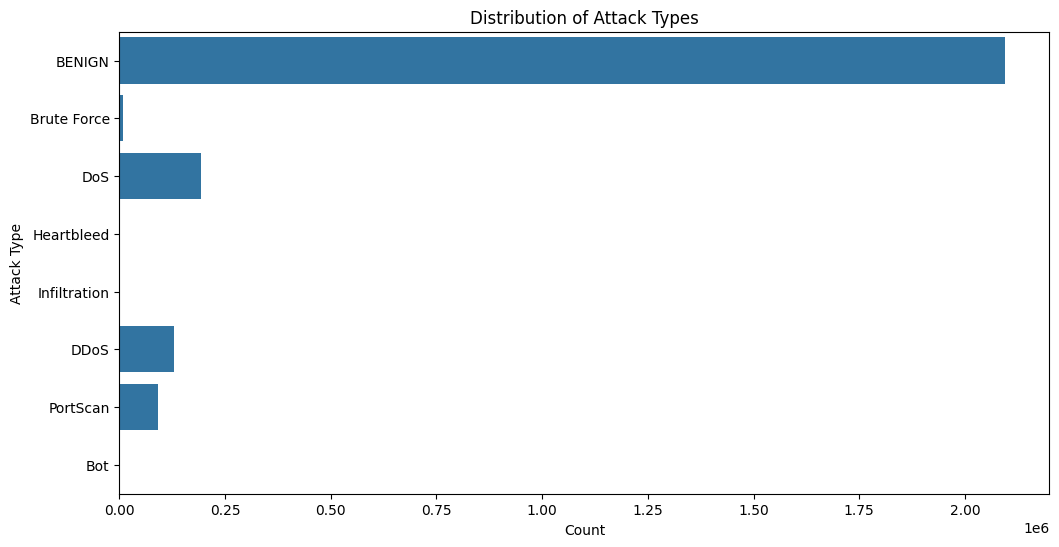

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(y=le.inverse_transform(y))
plt.title('Distribution of Attack Types')
plt.xlabel('Count')
plt.ylabel('Attack Type')
plt.show()

#Optimised resampling (Under-sampling + SMOTE)

In [15]:
print("\nClass distribution before resampling:")
print(y_train.value_counts())

# Define the resampling strategy
under_sampler = RandomUnderSampler(sampling_strategy={le.transform(['BENIGN'])[0]: 200000})
over_sampler = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

# Create the imblearn pipeline
resampling_pipeline = ImblearnPipeline(steps=[('u', under_sampler), ('o', over_sampler)])

# Apply the resampling pipeline to the training data ONLY
X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train, y_train)

print("\nClass distribution after resampling:")
print(y_train_resampled.value_counts())



Class distribution before resampling:
Attack Type
0    1466535
4     135621
3      89610
7      63486
2       6405
1       1364
6         25
5          8
Name: count, dtype: int64

Class distribution after resampling:
Attack Type
0    200000
1    200000
2    200000
3    200000
4    200000
5    200000
6    200000
7    200000
Name: count, dtype: int64


#Train and evaluate Machine learning models (Multi-class classification)

In [18]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Trains and evaluates a machine learning model."""
    print(f"\n--- Training {model_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nAccuracy for {model_name}: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
    return model


In [19]:
# Initialize models
lr_model = LogisticRegression(max_iter=1000, solver='saga', random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1)

# Train individual models
lr_model = train_and_evaluate_model(lr_model, X_train_resampled, y_train_resampled, X_test, y_test, "Logistic Regression")
dt_model = train_and_evaluate_model(dt_model, X_train_resampled, y_train_resampled, X_test, y_test, "Decision Tree")
rf_model = train_and_evaluate_model(rf_model, X_train_resampled, y_train_resampled, X_test, y_test, "Random Forest")
lgb_model = train_and_evaluate_model(lgb_model, X_train_resampled, y_train_resampled, X_test, y_test, "LightGBM")



--- Training Logistic Regression ---


/Users/princesingh/Downloads/timeseries/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Accuracy for Logistic Regression: 0.8540
Classification Report for Logistic Regression:

              precision    recall  f1-score   support

      BENIGN       1.00      0.83      0.91    628516
         Bot       0.01      0.73      0.02       584
 Brute Force       0.13      0.97      0.23      2745
        DDoS       0.66      1.00      0.79     38404
         DoS       0.88      0.93      0.91     58124
  Heartbleed       0.13      1.00      0.23         3
Infiltration       0.00      0.73      0.01        11
    PortScan       0.67      1.00      0.80     27208

    accuracy                           0.85    755595
   macro avg       0.44      0.90      0.49    755595
weighted avg       0.96      0.85      0.89    755595


--- Training Decision Tree ---

Accuracy for Decision Tree: 0.9984
Classification Report for Decision Tree:

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    628516
         Bot       0.59      0.97      0

/Users/princesingh/Downloads/timeseries/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Accuracy for LightGBM: 0.9669
Classification Report for LightGBM:

              precision    recall  f1-score   support

      BENIGN       1.00      0.97      0.98    628516
         Bot       0.19      0.97      0.31       584
 Brute Force       0.64      0.99      0.78      2745
        DDoS       0.90      0.97      0.93     38404
         DoS       0.92      0.95      0.93     58124
  Heartbleed       0.00      1.00      0.00         3
Infiltration       0.00      0.64      0.00        11
    PortScan       0.93      0.97      0.95     27208

    accuracy                           0.97    755595
   macro avg       0.57      0.93      0.61    755595
weighted avg       0.98      0.97      0.97    755595



Training Ensemble Model (Voting Classifier)

In [20]:
# Create a Voting Classifier with the best-performing models
voting_clf = VotingClassifier(
    estimators=[('lr', lr_model), ('rf', rf_model), ('lgbm', lgb_model)],
    voting='soft'
)
voting_clf = train_and_evaluate_model(voting_clf, X_train_resampled, y_train_resampled, X_test, y_test, "Voting Classifier")


--- Training Voting Classifier ---


/Users/princesingh/Downloads/timeseries/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16334
[LightGBM] [Info] Number of data points in the train set: 1600000, number of used features: 68
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/princesingh/Downloads/timeseries/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Accuracy for Voting Classifier: 0.9929
Classification Report for Voting Classifier:

              precision    recall  f1-score   support

      BENIGN       1.00      0.99      1.00    628516
         Bot       0.32      0.99      0.49       584
 Brute Force       0.91      1.00      0.95      2745
        DDoS       0.99      1.00      1.00     38404
         DoS       0.97      1.00      0.99     58124
  Heartbleed       0.05      1.00      0.10         3
Infiltration       0.01      0.73      0.02        11
    PortScan       0.97      1.00      0.98     27208

    accuracy                           0.99    755595
   macro avg       0.65      0.96      0.69    755595
weighted avg       1.00      0.99      0.99    755595



#Deep learning (CNN-LSTM Model)

In [21]:
X_train_dl = np.reshape(X_train_resampled, (X_train_resampled.shape[0], X_train_resampled.shape[1], 1))
X_test_dl = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# The target variable does not need to be one-hot encoded if using 'sparse_categorical_crossentropy'
y_train_dl = y_train_resampled
y_test_dl = y_test

# Define the CNN-LSTM model
cnn_lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_dl.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(100, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

# Compile the model
cnn_lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_lstm_model.summary()

# Train the model
history = cnn_lstm_model.fit(
    X_train_dl, y_train_dl,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    verbose=1
)

/Users/princesingh/Downloads/timeseries/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 76, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 38, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,240 (286.09 KB)

 Trainable params: 73,240 (286.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 247s 98ms/step - accuracy: 0.9348 - loss: 0.1909 - val_accuracy: 0.9745 - val_loss: 0.0877
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 243s 97ms/step - accuracy: 0.9812 - loss: 0.0592 - val_accuracy: 0.9924 - val_loss: 0.0396
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 228s 91ms/step - accuracy: 0.9850 - loss: 0.0470 - val_accuracy: 0.9973 - val_loss: 0.0423
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 243s 97ms/step - accuracy: 0.9866 - loss: 0.0416 - val_accuracy: 0.9970 - val_loss: 0.0285
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 249s 99ms/step - accuracy: 0.9877 - loss: 0.0385 - val_accuracy: 0.9913 - val_loss: 0.0563
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 249s 100ms/step - accuracy: 0.9887 - loss: 0.0357 - val_accuracy: 0.9989 - val_loss: 0.0222
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 736s 294ms/step - accuracy: 0.9893 - loss: 0.0335 - val_accuracy: 0.9995 - val_loss: 0.0126
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 257s 103ms/step - accurac

#Anomaly Detection

In [31]:
# We'll label BENIGN as 1 (normal) and all attacks as -1 (anomaly).
benign_label_numeric = le.transform(['BENIGN'])[0]
X_train_benign = X_train[y_train == benign_label_numeric] 
y_train_anomaly = np.where(y_train == benign_label_numeric, 1, -1)
y_test_anomaly = np.where(y_test == benign_label_numeric, 1, -1)

# Initialize results list to store evaluation metrics
results = []

Training Isolation Forest

In [32]:
iso_forest = IsolationForest(contamination='auto', random_state=42, n_jobs=-1)
iso_forest.fit(X_train)

y_pred_iso = iso_forest.predict(X_test)
print("Accuracy for Isolation Forest:", accuracy_score(y_test_anomaly, y_pred_iso))
print("Classification Report for Isolation Forest:\n", classification_report(y_test_anomaly, y_pred_iso, zero_division=0))
results.append({
    'model': 'Isolation Forest',
    'accuracy': accuracy_score(y_test_anomaly, y_pred_iso),
    'report': classification_report(y_test_anomaly, y_pred_iso, output_dict=True, zero_division=0)
})

Accuracy for Isolation Forest: 0.8230652664456488
Classification Report for Isolation Forest:
               precision    recall  f1-score   support

          -1       0.46      0.27      0.34    127079
           1       0.86      0.93      0.90    628516

    accuracy                           0.82    755595
   macro avg       0.66      0.60      0.62    755595
weighted avg       0.80      0.82      0.80    755595



Local Outlier Factor (LOF) with GridSearchCV

In [36]:
def anomaly_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='binary', pos_label=-1)

scorer = make_scorer(anomaly_f1_score)

# Train LOF on benign data only
lof = LocalOutlierFactor(novelty=True, contamination=0.1)

# Define the parameter grid for GridSearchCV
params = {'n_neighbors': [5, 10, 15]}

# Perform manual cross-validation for LOF
best_params = None
best_f1 = -1
for n_neighbors in params['n_neighbors']:
    lof.set_params(n_neighbors=n_neighbors)
    lof.fit(X_train_benign)  
    y_pred_lof = lof.predict(X_test) 
    f1 = f1_score(y_test_anomaly, y_pred_lof, average='binary', pos_label=-1) 
    print(f"n_neighbors: {n_neighbors}, F1-Score: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_params = {'n_neighbors': n_neighbors}

# Train the best LOF model
lof.set_params(**best_params)
lof.fit(X_train_benign)
y_pred_lof = lof.predict(X_test)

# Evaluate the best LOF model
print("--- Local Outlier Factor ---")
print("Best Parameters:", best_params)
print("Accuracy:", accuracy_score(y_test_anomaly, y_pred_lof))
print("Classification Report:\n", classification_report(y_test_anomaly, y_pred_lof, zero_division=0))
results.append({
    'model': 'Local Outlier Factor',
    'accuracy': accuracy_score(y_test_anomaly, y_pred_lof),
    'report': classification_report(y_test_anomaly, y_pred_lof, output_dict=True, zero_division=0)
})

n_neighbors: 5, F1-Score: 0.6468
n_neighbors: 10, F1-Score: 0.6479
n_neighbors: 15, F1-Score: 0.6463
--- Local Outlier Factor ---
Best Parameters: {'n_neighbors': 10}
Accuracy: 0.867791607938115
Classification Report:
               precision    recall  f1-score   support

          -1       0.59      0.72      0.65    127079
           1       0.94      0.90      0.92    628516

    accuracy                           0.87    755595
   macro avg       0.76      0.81      0.78    755595
weighted avg       0.88      0.87      0.87    755595



#Deep learning

Autoencoder with KerasTuner

In [34]:
# We train the autoencoder ONLY on benign (normal) data.
X_train_benign = X_train[y_train == benign_label_numeric]

# Define the Autoencoder architecture
input_dim = X_train_benign.shape[1]
encoding_dim = 32

input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation="relu")(input_layer)
encoder = Dense(64, activation="relu")(encoder)
encoder = Dense(encoding_dim, activation="relu")(encoder)

decoder = Dense(64, activation='relu')(encoder)
decoder = Dense(128, activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder) 

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(
    X_train_benign, X_train_benign,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.2,
    verbose=1
)

# Evaluate the Autoencoder
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)


benign_test_indices = np.where(y_test == benign_label_numeric)[0]
threshold = np.quantile(mse[benign_test_indices], 0.95)
print(f"Anomaly threshold (MSE): {threshold}")

y_pred_auto = np.where(mse > threshold, -1, 1)

print("\nAccuracy for Autoencoder:", accuracy_score(y_test_anomaly, y_pred_auto))
print("Classification Report for Autoencoder:\n", classification_report(y_test_anomaly, y_pred_auto, zero_division=0))

results.append({
    'model': 'Autoencoder',
    'accuracy': accuracy_score(y_test_anomaly, y_pred_auto),
    'report': classification_report(y_test_anomaly, y_pred_auto, output_dict=True, zero_division=0)
})

Epoch 1/20
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6384 - val_loss: 0.8053
Epoch 2/20
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6250 - val_loss: 0.8043
Epoch 3/20
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6234 - val_loss: 0.7985
Epoch 4/20
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6187 - val_loss: 0.7984
Epoch 5/20
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6174 - val_loss: 0.7963
Epoch 6/20
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6165 - val_loss: 0.7963
Epoch 7/20
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.6163 - val_loss: 0.7962
Epoch 8/20
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6161 - val_loss: 0.7957
Epoch 9/20
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6162 - val_loss: 0.7969
Epoch 10/20
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.6169 - val_loss: 0.7967
Epoch 11/20
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.6165 - val_loss: 0.7964
Epoch 12/20
4583/4583 ━━━━━━

Time-Series Approach (1D-CNN)

In [35]:
# Reshape data for 1D-CNN
X_train_cnn = X_train_benign.reshape((X_train_benign.shape[0], X_train_benign.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid') 
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

y_train_cnn = np.ones(X_train_cnn.shape[0])  

cnn_model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=256, validation_split=0.2, verbose=1)

# Evaluate the 1D-CNN
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn = np.where(y_pred_cnn > 0.5, 1, -1) 

print("--- 1D-CNN ---")
print("Accuracy:", accuracy_score(y_test_anomaly, y_pred_cnn))
print("Classification Report:\n", classification_report(y_test_anomaly, y_pred_cnn, zero_division=0))
results.append({
    'model': '1D-CNN',
    'accuracy': accuracy_score(y_test_anomaly, y_pred_cnn),
    'report': classification_report(y_test_anomaly, y_pred_cnn, output_dict=True, zero_division=0)
})

/Users/princesingh/Downloads/timeseries/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 1.0000 - loss: 5.4550e-04 - val_accuracy: 1.0000 - val_loss: 1.4190e-07
Epoch 2/10
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 1.0000 - loss: 4.9345e-08 - val_accuracy: 1.0000 - val_loss: 1.3194e-08
Epoch 3/10
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 1.0000 - loss: 8.7562e-09 - val_accuracy: 1.0000 - val_loss: 5.6188e-09
Epoch 4/10
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 1.0000 - loss: 3.8308e-09 - val_accuracy: 1.0000 - val_loss: 2.4628e-09
Epoch 5/10
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 1.0000 - loss: 1.8623e-09 - val_accuracy: 1.0000 - val_loss: 1.5721e-09
Epoch 6/10
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 1.0000 - loss: 1.4931e-09 - val_accuracy: 1.0000 - val_loss: 1.4235e-09
Epoch 7/10
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 1.0000 - loss: 1.3995e-09 - val_accuracy: 1.0000 - val_loss: 1.3710e-09
Epoch 8/10
4583/4583 ━━━━━━


--- Performance Comparison of Anomaly Detection Models ---
                  Model  Accuracy  Precision    Recall  F1-Score
0      Isolation Forest  0.823065   0.456531  0.273224  0.341855
1           Autoencoder  0.837115   0.529945  0.278803  0.365380
2                1D-CNN  0.831816   0.000000  0.000000  0.000000
3  Local Outlier Factor  0.867792   0.586757  0.723345  0.647931


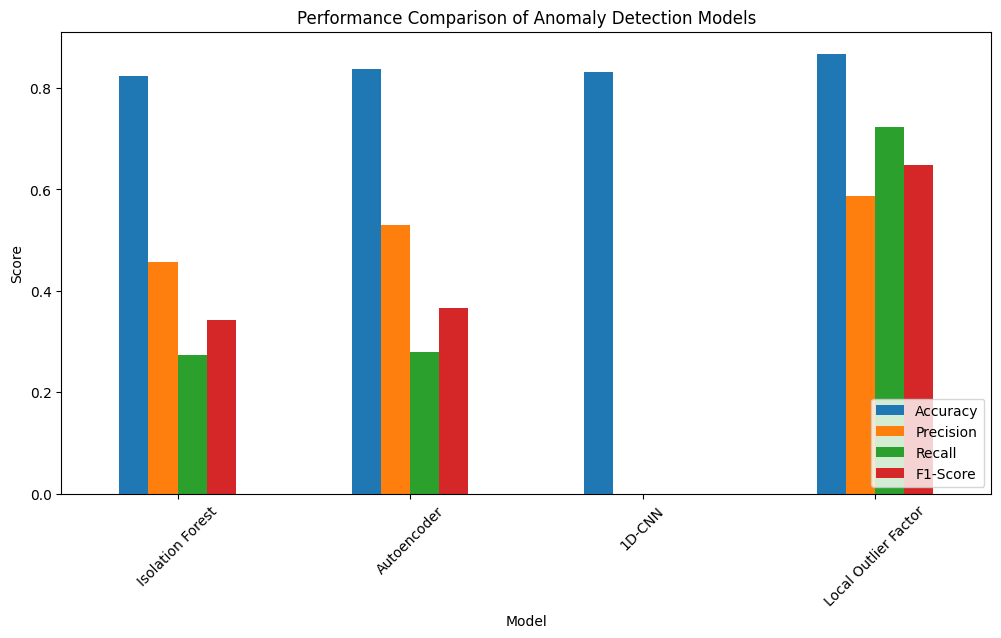

In [37]:
# Extract key metrics from the results
comparison_data = []
for result in results:
    model_name = result['model']
    report = result['report']
    accuracy = result['accuracy']
    precision = report['-1']['precision']  
    recall = report['-1']['recall']       
    f1_score = report['-1']['f1-score']    
    comparison_data.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    })

comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print("\n--- Performance Comparison of Anomaly Detection Models ---")
print(comparison_df)

comparison_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(12, 6), title='Performance Comparison of Anomaly Detection Models'
)
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()